In [1]:
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
import yfinance as yf
from datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

from src.modules import stock
from src.tests import test

            Date         High          Low         Open        Close   Volume  \
0     2012-01-03   179.479996   175.550003   175.889999   179.029999  5110800   
1     2012-01-04   180.500000   176.070007   179.210007   177.509995  4205200   
2     2012-01-05   178.250000   174.050003   175.940002   177.610001  3809100   
3     2012-01-06   184.649994   177.500000   178.070007   182.610001  7008400   
4     2012-01-09   184.369995   177.000000   182.759995   178.559998  5056900   
...          ...          ...          ...          ...          ...      ...   
2609  2022-05-16  2279.850098  2207.080078  2262.000000  2216.209961  3728300   
2610  2022-05-17  2316.000000  2225.530029  2265.500000  2307.370117  3822400   
2611  2022-05-18  2257.060059  2124.979980  2228.790039  2142.250000  5419000   
2612  2022-05-19  2200.679932  2123.860107  2125.610107  2146.379883  4402900   
2613  2022-05-20  2197.409912  2142.149902  2191.370117  2153.350098  1681164   

        Adj Close  
0      

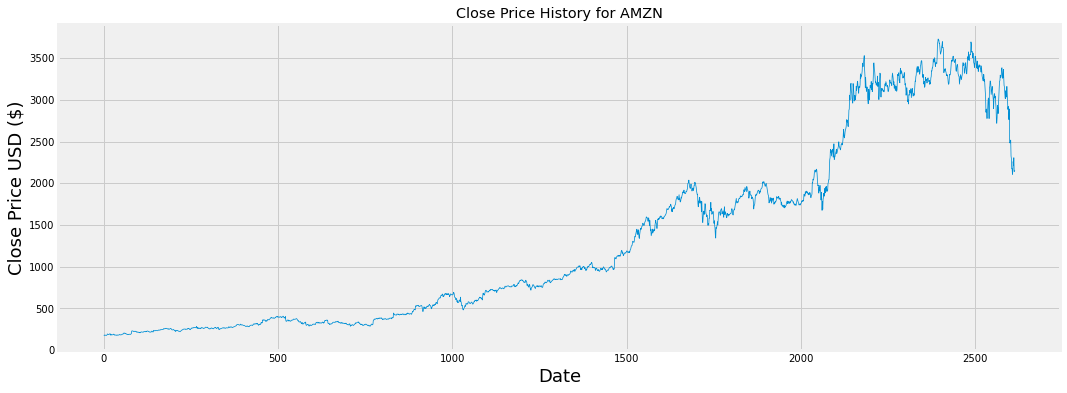

[array([0.0008719 , 0.00044438, 0.00047251, 0.00187879, 0.0007397 ,
       0.00095908, 0.00083533, 0.        , 0.00070033, 0.0016116 ,
       0.00379977, 0.00520886, 0.00421884, 0.00285756, 0.00311351,
       0.00333851, 0.00489105, 0.00546762, 0.00456197, 0.00520605,
       0.00099284, 0.00162847, 0.00330476, 0.00202786, 0.00232318,
       0.002686  , 0.00254537, 0.00270287, 0.00440447, 0.00432291,
       0.00240193, 0.00112502, 0.00184785, 0.00178035, 0.00130784,
       0.00083252, 0.00090002, 0.00073127, 0.00221349, 0.00105753,
       0.00115596, 0.00094784, 0.00121784, 0.00145128, 0.00220505,
       0.00329351, 0.00235974, 0.00209817, 0.00243568, 0.00178035,
       0.00239068, 0.00256506, 0.00269725, 0.0046126 , 0.00444385,
       0.00463229, 0.0053748 , 0.00757704, 0.00829987, 0.00709609])]
[0.00806642382588374]

[array([0.0008719 , 0.00044438, 0.00047251, 0.00187879, 0.0007397 ,
       0.00095908, 0.00083533, 0.        , 0.00070033, 0.0016116 ,
       0.00379977, 0.00520886, 0.00

C:\Users\jayta\Documents\Github\Stock_Prediction\Final_Model\src\tests\test.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


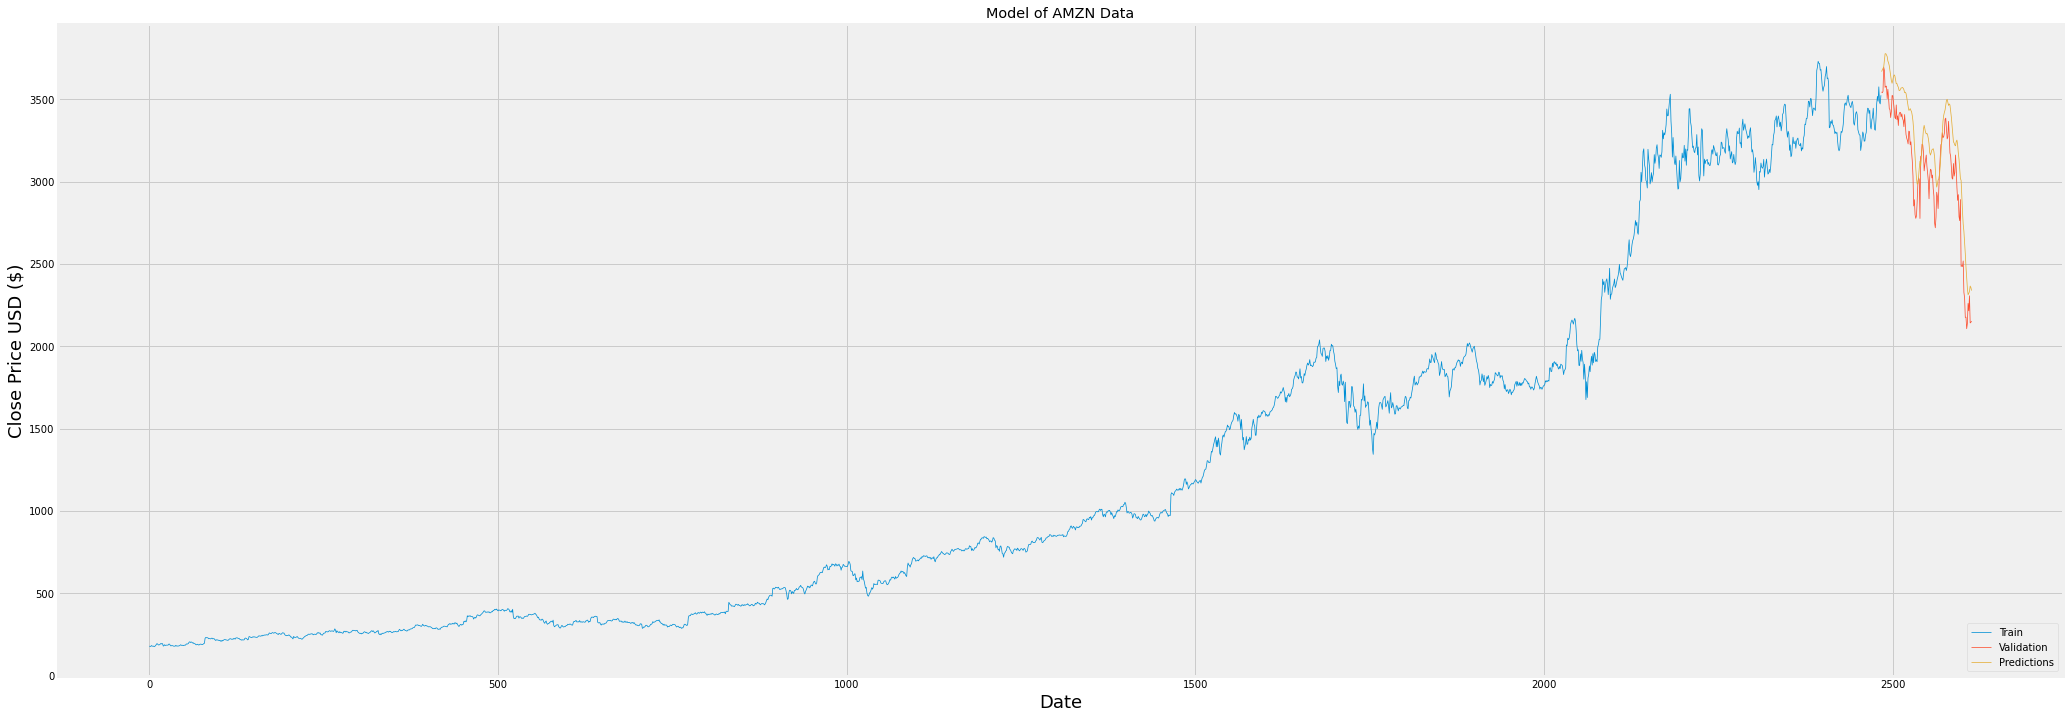

            Close  Predictions
2484  3545.679932  3669.041504
2485  3540.699951  3679.674561
2486  3549.000000  3688.368896
2487  3696.060059  3696.635986
2488  3676.570068  3739.863281
...           ...          ...
2609  2216.209961  2321.757080
2610  2307.370117  2333.261963
2611  2142.250000  2366.332031
2612  2146.379883  2357.991699
2613  2153.350098  2338.745605

[130 rows x 2 columns]


In [2]:
ticker = 'AMZN'
df = stock.data_pull(ticker)
print(df)

stock.visualize_raw(ticker, df)

data_processed = stock.preprocess(df)

#scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data_processed)

#use 95% of dataset as train data and split data into test and train
training_data_len = int(np.ceil( len(scaled_data) * .95 ))
train_data = scaled_data[0:int(training_data_len), :]

#split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
#convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

#reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(128,
               return_sequences=True,
               input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(32))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=2)

# Create a new array containing scaled values 
test_data = scaled_data[training_data_len - 60: , :]

# Create the data sets x_test and y_test
x_test = []
y_test = data_processed[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))

#visualize results
test.visualize_model(ticker, df, training_data_len, predictions)